# PREDICTONG FAKE VS REAL NEWS - NAIVE BAYES MODEL



This project aims to develop a machine learning model capable of distinguishing between real and fake news based on key attributes such as the news content, title, and its associated label (real or fake). Additionally, the model can optionally incorporate sentiment labels (positive, negative, or neutral) to enhance its predictive capabilities. The primary goal of this project is to contribute to a safer and more reliable information ecosystem by ensuring that individuals have access to accurate and up-to-date news, thereby combating misinformation and fostering informed decision-making.

Data from: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification/data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.sparse import hstack
from textblob import TextBlob


Importing all necessary liabraries


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-classification/WELFake_Dataset.csv


In [3]:
df = pd.read_csv('/kaggle/input/fake-news-classification/WELFake_Dataset.csv')

df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


Importing the dataset from Kaggle and verifying it. 

# EDA - Exploratory Data Analysis

In [79]:
df.shape

(72134, 4)

Identifying the size of the dataset. Original dataset had 72134 rows and 4 column.


In [6]:
df.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

This dataset has 4 columns Unnamed: 0, title, text, and label. 

Within each of those 4 columns we are checking for Null values (Missing Variables) within the dataset. The Title column had 558 misisng variables, which is less than 1% of overall data; Text colum had 39 mising variables, which is less than 1% of overall data. Since both columns contain missing variables that are less than 1% of overall dataset, we will drop those variables from the dataset.


In [7]:
print("\nDuplicate Rows:", df.duplicated().sum())


Duplicate Rows: 0


Here we are checking if we have any duplicates, overall we can see that dataset have 0 duplicate rows, therefore no action is required.

In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)

df = df.dropna(subset=['title'])
df = df.dropna(subset=['text'])

We have droped a column Unnamed: 0, and we have droped missing variables in 2 columns: title, and text. We have droped Unnamed: 0 column since it had no purpose for our research. We also droped misisng variables in title and text, since both of those columns contain textvariables, therefore we can not replace them with the most common variable, the only posisble solution is to drop them. 

In [64]:
df.shape

(71537, 3)

After dropping a column and rows with misisng variables we are verifying the size of the dataframe, to ensure everything was droped correctly. Original dataframe before the drop had a size of 72134 rows & 4 columns, after we droped 1 column and 597 rows, we got the size of 71537 rows and 3 columns. 


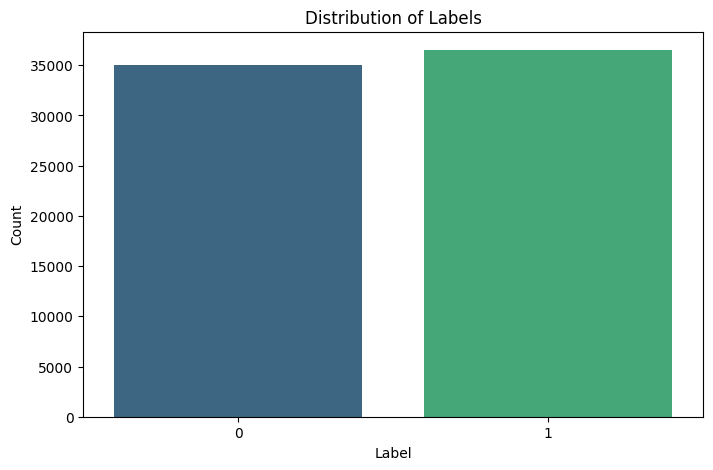

In [65]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, palette='viridis')
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


To inform the development of future models, it is essential to analyze the distribution of labels (True and Fake) within the dataset. Our analysis indicates that the labels are approximately balanced, which is a critical factor that can significantly influence the performance of future models. A balanced label distribution helps mitigate the risk of the model favoring one label over the other, thereby promoting fair and unbiased predictions. This balanced dataset provides a strong foundation for training a model that can effectively differentiate between true and fake news with minimal bias.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


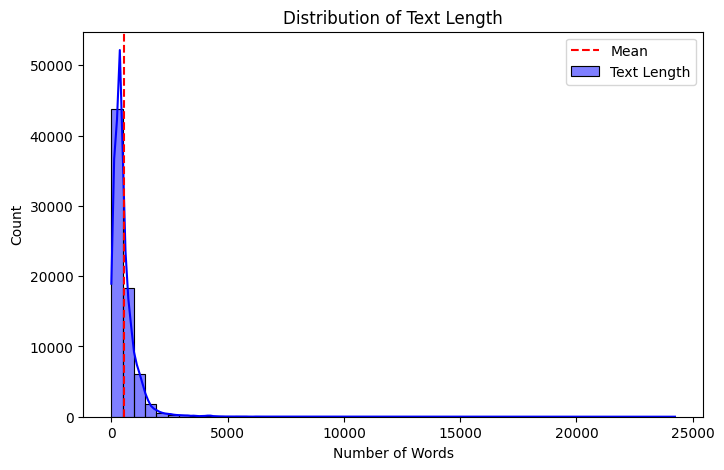

In [66]:
df['text'] = df['text'].fillna("").astype(str)
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
df['title'] = df['title'].fillna("").astype(str)
df['title_length'] = df['title'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df['text_length'], kde=True, bins=50, color='blue', label='Text Length')
plt.axvline(df['text_length'].mean(), color='red', linestyle='--', label='Mean')
plt.title("Distribution of Text Length")
plt.xlabel("Number of Words")
plt.legend()
plt.show()

In this analysis, we aim to examine the distribution of text lengths within the dataset. Our findings indicate that the majority of the text entries are of similar length, suggesting a consistent structure in the data. This uniformity in text length may simplify preprocessing steps and contribute to the stability of feature extraction methods, ultimately supporting the development of robust predictive models.

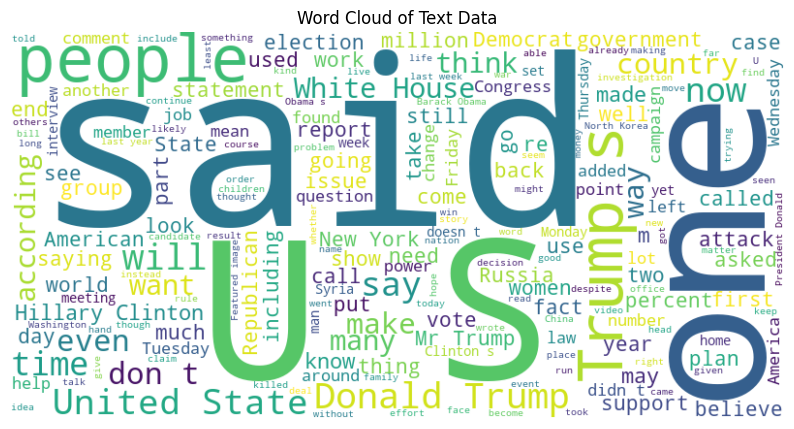

In [67]:
text_data = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Text Data")
plt.show()

Here we are trying to identify the most frequently occurring words, which can indicate key concepts, topics, or sentiments in the text data. The bigger the words in the text the more commonly used they are. 

#  Naive Bayes Model 

##  Model 1

Accuracy: 0.8487559407324574
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      7081
           1       0.83      0.88      0.85      7227

    accuracy                           0.85     14308
   macro avg       0.85      0.85      0.85     14308
weighted avg       0.85      0.85      0.85     14308



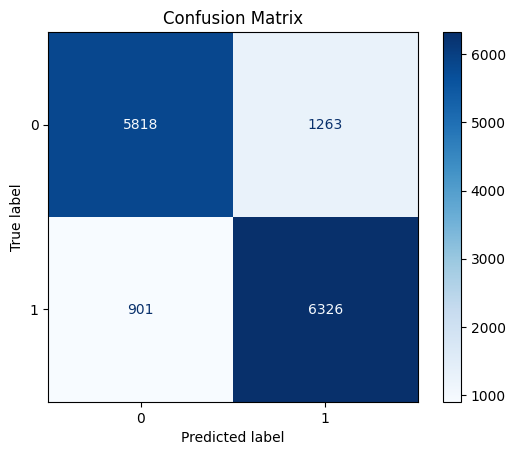

In [91]:
df['combined_text'] = df['title'] + " " + df['text'] 
X = df['combined_text'] 
y = df['label']  
vectorizer = TfidfVectorizer(max_features=5000)
X_text_tfidf = vectorizer.fit_transform(X)  

X_train, X_test, y_train, y_test = train_test_split(X_text_tfidf, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(y_train.value_counts()) 
print(y_test.value_counts())   

Overall this model has a ballanced precission, recall and f1-score. Accuracy is at 85%. 

It is possible that a combination of factors encouraged good performaance of the model. Usually when selecting a model that suits a data set and the purpose of reaserch it improves performance. Based on our research Naive Bayes is ideal for categorical data and especially for text data. It is  possible that TfidfVectorizer extracted meaningfull information patterns, which created a good ballanced performance of the model. Our dataset after cleaning had slightly over 72000 rows, after the split we trained the model on about 58000 rows, and tested the model on 14 000 rows, out of 14 000 rows we had roughly 7081 of 0 class; and about 7227 of 1 class; this possibly also helped us to have ballanced precission, recall, and f1-score. We also chose to train the model on 80% of the data and test on 20% - which was a good decision, since the results are not overfiting the model. 


0 - Fake
1- Real

The Model correctly predicted 5821 Fake News (0), and 6320 Real News (1). It Incorectly predicated 907 Real News, and 1258 Fake News. 

## Model 2

## Modle 2 with the same vectrorizer for both x and y

Accuracy: 0.8610567514677103

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.83      0.86      7081
           1       0.84      0.89      0.87      7227

    accuracy                           0.86     14308
   macro avg       0.86      0.86      0.86     14308
weighted avg       0.86      0.86      0.86     14308



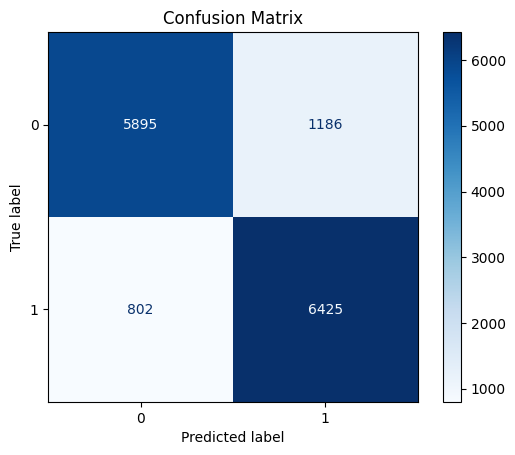

In [94]:
df['combined_text'] = df['title'] + " " + df['text']

X = df['combined_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(
    max_features=5000,     
    ngram_range=(1, 2),     
    max_df=0.9,            
    min_df=5               
)


X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(y_train.value_counts()) 
print(y_test.value_counts())   

This model Performed slightly beter(~1.24% increased) than Model 1. The model performance is still ballanced. We assume that hyperparameter tunning such as max_df, and min_df helped to improve feature quality, which results in better accuracy. 

In order to improve the model preformance we have done Hyperparameter Tuning, which included max_features, ngram_range, max_df, min_df. max_features - control/limit the maximum number of features to consider when building a model; ngram_range - determines the range of sequences of words or characters to be considered as features during the text processing; max_df - Improve Feature Selection by Removing High-Frequency Terms (Like The, A, An etc); min_df - It Removes Rare Terms and Reduce Sparsity.

Here is what we set as a Hyperparameter Tuning: 
    max_features=5000,     
    ngram_range=(1, 2),     
    max_df=0.9,            
    min_df=5  

0 - Fake
1- Real

The model corectly predicts 5895 Fake News articles, and 6425 Real News, while it inccorectly predicts 1186 Fake News and  802 Real News. 

## Model 2 with 2 different vectrorizer for both x and y

Accuracy: 0.8487559407324574
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      7081
           1       0.83      0.88      0.85      7227

    accuracy                           0.85     14308
   macro avg       0.85      0.85      0.85     14308
weighted avg       0.85      0.85      0.85     14308



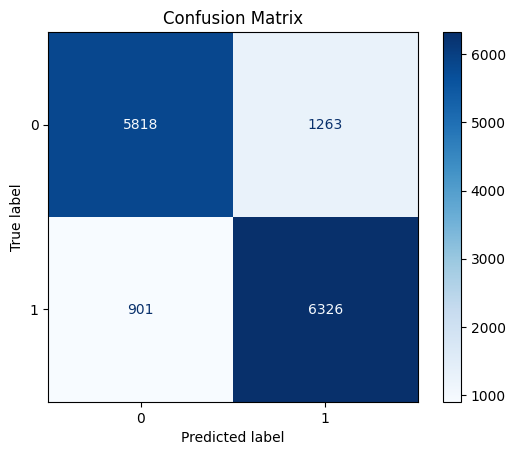

In [93]:
df['combined_text'] = df['title'] + " " + df['text'] 
X = df['combined_text'] 
y = df['label']  

vectorizer = TfidfVectorizer(max_features=5000)
X_text_tfidf = vectorizer.fit_transform(X)  

X_train, X_test, y_train, y_test = train_test_split(X_text_tfidf, y, test_size=0.2, random_state=42)
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()


For this model we set test size to 20%, which left 80% for training. This model demonstrates no improvement in performance compared to Model 1. The overall performance remains balanced, as indicated by the precision, recall, and F1-scores for both labels (0 and 1). These metrics suggest that the model is equally effective in identifying real and fake news. 

This model correctly predicted 5818 fakes news and 6326 real news, it incorectly predicted 1263 fakes news and 901 real news. 

We assume that hyperparameter tunning such as max_df, and min_df helped to improve featire quality, which results in better accuracy. We have done Hyperparameter Tuning, which included  max_features -  control/limit the maximum number of features to consider when building a model.

As a result, the adjusted feature representation better aligns with the underlying patterns in the dataset, contributing to the observed performance.

The confusion matrix and classification report further validate the balanced performance, with the model achieving a strong trade-off between precision and recall for both classes. This highlights the model's ability to generalize effectively across different types of input data.
 

## Model 3


Accuracy: 0.7940546081446277

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79     10595
           1       0.79      0.81      0.80     10867

    accuracy                           0.79     21462
   macro avg       0.79      0.79      0.79     21462
weighted avg       0.79      0.79      0.79     21462



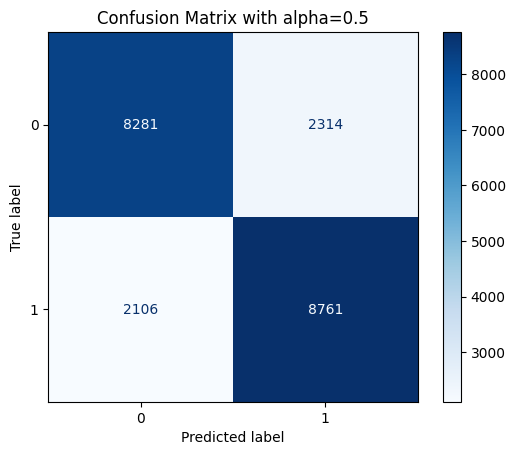

In [70]:
df['combined_text'] = df['title'] + " " + df['text']

X = df['combined_text']
y = df['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(
    max_features=5000,     
    ngram_range=(1, 2),    
    max_df=0.9,             
    min_df=0.4               
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

alpha_value = 0.5 
model = MultinomialNB(alpha=alpha_value)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix with alpha={alpha_value}")
plt.show()


In [ ]:
print(y_train.value_counts()) 
print(y_test.value_counts())   

The model’s precision, recall, and F1-score are relatively balanced between both classes (fake and real news), showing that it performs well on both types of news articles. The confusion matrix further reveals that the model made a slightly higher number of false positive predictions for fake news than false negatives for real news.

The modle correctly predicted 8281 fake news and 8761 real news, it incorectly predicted 2314 fake news and 2106 real news. 

The model preformance droped to 79%.


# Model 4

Accuracy: 0.847777467151244
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84     10595
           1       0.83      0.88      0.85     10867

    accuracy                           0.85     21462
   macro avg       0.85      0.85      0.85     21462
weighted avg       0.85      0.85      0.85     21462



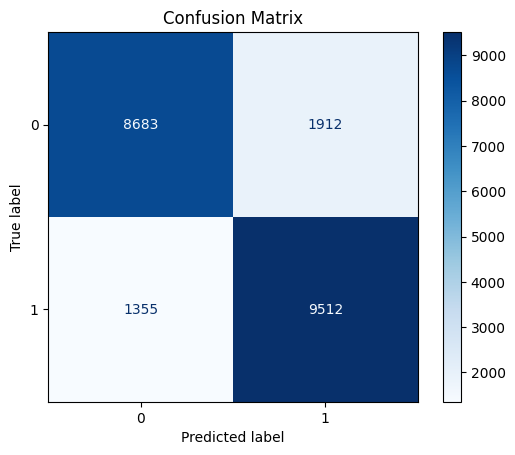

In [97]:
X = df['combined_text']  
y = df['label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)
X_text_tfidf = vectorizer.fit_transform(X) 

X_train_tfidf = vectorizer.transform(X_train)  
X_test_tfidf = vectorizer.transform(X_test)    

alpha_value = 0.5
model = MultinomialNB(alpha=alpha_value)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(y_train.value_counts()) 
print(y_test.value_counts())   

We have added an alpha set to 0.5, we also set test size to 30%, which left us with 70% for training, and random state to 42. The alpha that we added to the model is intended to smooth the parameters and ensure we are not overfiting the model. The model's performance remains relatively balanced, maintaining a strong trade-off between precision and recall for both classes. While the slight accuracy decrease highlights the sensitivity of the model to hyperparameter changes, the balanced results indicate robustness across varying configurations. The model acciracy is 85%.

# Data Edditing - In Order to improve model performance


# Sentiment

In [5]:
df['combined_text'] = df['title'] + " " + df['text']
df['sentiment'] = df['combined_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_label'] = df['sentiment'].apply(
    lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral'
)

print(df)


                                                   title  \
0      LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
2      UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3      Bobby Jindal, raised Hindu, uses story of Chri...   
4      SATAN 2: Russia unvelis an image of its terrif...   
5      About Time! Christian Group Sues Amazon and SP...   
...                                                  ...   
72129  Russians steal research on Trump in hack of U....   
72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132  Trump tussle gives unpopular Mexican leader mu...   
72133  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                                    text  label  \
0      No comment is expected from Barack Obama Membe...      1   
2       Now, most of the demonstrators gathered last ...      1   
3      A dozen politically active pastors came here f...      0   
4      The 

Here we are trying trying to improve model performance by feature engineering and sentiment analysis. 

Feature Engineering:
We have combined text and title and saved results to combined_text.

Sentiments Analysis:
Based on combined_text collumn we have done sentiment analysis, and saved the results to sentiment_label columns. Sentiment analysis has 3 variables (Positive, Neutral, Negative) that can be used to rate the combined_text collumn. 

As a result we end up with two new columns sentiment and sentiment_label. Sentiment has a sentiment score based on which sentiment_lable receives it's rating. 

After all data manipulation our dataset changed it's size to 71537 rows and 6 coumns.


In [72]:
df

,title,text,label,text_length,title_length,combined_text,sentiment,sentiment_label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,871,18,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,0.034641,positive
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,34,18,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,0.190402,positive
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,1321,16,"Bobby Jindal, raised Hindu, uses story of Chri...",0.111493,positive
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,329,16,SATAN 2: Russia unvelis an image of its terrif...,0.013342,positive
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,244,13,About Time! Christian Group Sues Amazon and SP...,-0.100461,negative
...,...,...,...,...,...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,735,11,Russians steal research on Trump in hack of U....,0.092339,positive
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,604,10,WATCH: Giuliani Demands That Democrats Apolog...,-0.044864,negative
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,477,10,Migrants Refuse To Leave Train At Refugee Camp...,0.103722,positive
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0,559,10,Trump tussle gives unpopular Mexican leader mu...,-0.018866,negative


Here we are verifying that the changes have been implemented. 

The numbers of columns have chnaged and we can see combined_text, sentiment and  sentiment_score is in the dataframe. 

# Model 5

/tmp/ipykernel_30/2072294025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sentiment_label_encoded'] = encoder.fit_transform(X['sentiment_label'])


Accuracy: 0.848825831702544
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      7081
           1       0.83      0.88      0.85      7227

    accuracy                           0.85     14308
   macro avg       0.85      0.85      0.85     14308
weighted avg       0.85      0.85      0.85     14308



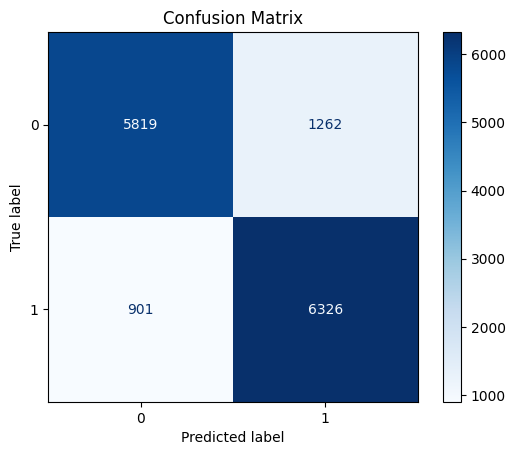

In [7]:
X = df[['combined_text', 'sentiment_label']]  
y = df['label']  

vectorizer = TfidfVectorizer(max_features=5000)
X_text_tfidf = vectorizer.fit_transform(X['combined_text']) 

encoder = LabelEncoder()
X['sentiment_label_encoded'] = encoder.fit_transform(X['sentiment_label'])  
X_non_text = X[['sentiment_label_encoded',]].values  

X_combined = hstack([X_text_tfidf, X_non_text])

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()


In [8]:
print(y_train.value_counts()) 
print(y_test.value_counts())   

label
1    29282
0    27947
Name: count, dtype: int64
label
1    7227
0    7081
Name: count, dtype: int64


Here in this model we are feeding 'combined_text', 'sentiment_label' in order to predict lable. The 'sentiment_label' was created by us, in order to  improve the model performance. We did encode the 'sentiment_label', into binaries, in order for the model to better unferstand the sentiment lables. Based on our results our model performed with ~85%, the model seems to have a ballanced perfomance based on the reuslts of precission, recall, and f1-score. 

0 - Fake 1- Real

We can see that our model correctly predicted  5819 fake news, and 6326 real news, meanwhile it guessed incorrectly 1262 fake news, and 901 real news. 

# Model 6

/tmp/ipykernel_30/756725450.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sentiment_label_encoded'] = encoder.fit_transform(X['sentiment_label'])


Accuracy: 0.8478613363153481
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      8860
           1       0.83      0.87      0.85      9025

    accuracy                           0.85     17885
   macro avg       0.85      0.85      0.85     17885
weighted avg       0.85      0.85      0.85     17885



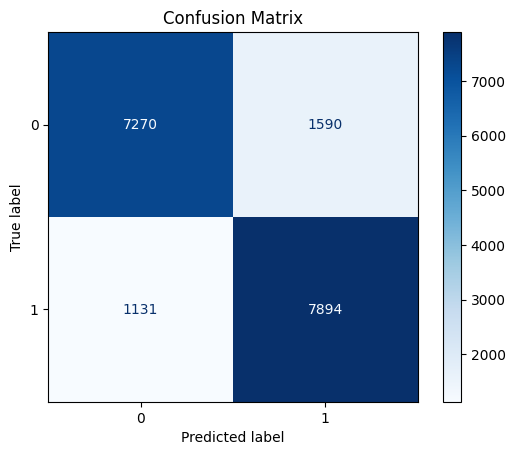

In [14]:
X = df[['combined_text', 'sentiment_label']]  
y = df['label']  

vectorizer = TfidfVectorizer(max_features=5000)
X_text_tfidf = vectorizer.fit_transform(X['combined_text']) 

encoder = LabelEncoder()
X['sentiment_label_encoded'] = encoder.fit_transform(X['sentiment_label'])  
X_non_text = X[['sentiment_label_encoded',]].values  

X_combined = hstack([X_text_tfidf, X_non_text])

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(y_train.value_counts()) 
print(y_test.value_counts())   

In this model we are feeding 'combined_text', 'sentiment_label' in order to predict lable. The 'sentiment_label' was created by us, in order to  improve the model performance. We did encode the 'sentiment_label', into binaries, in order for model to better understand the sentiment lables. We set test size to 25%, which reduced the training size to 75%. The model accuracy is 85%. We can see the minor changes in precission, recall,a nd f1-score, but overall it is still ballanced. 

0 - Fake 1- Real

Overall this model correctly predicted 7270 fake news and 7894 real news, it also incorectly predicted 1590 fake news and 1131 real news. 



# Model 7

/tmp/ipykernel_30/4229882870.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sentiment_label_encoded'] = encoder.fit_transform(X['sentiment_label'])


Accuracy: 0.8421861895443109
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84     10595
           1       0.83      0.86      0.85     10867

    accuracy                           0.84     21462
   macro avg       0.84      0.84      0.84     21462
weighted avg       0.84      0.84      0.84     21462



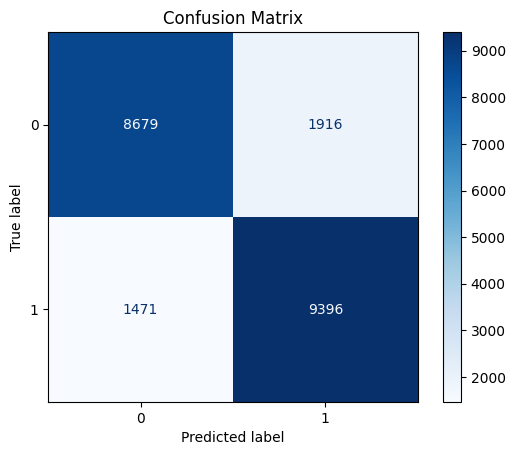

In [17]:
X = df[['combined_text', 'sentiment_label']]  
y = df['label']  

vectorizer = TfidfVectorizer(max_features=1000)
X_text_tfidf = vectorizer.fit_transform(X['combined_text']) 

encoder = LabelEncoder()
X['sentiment_label_encoded'] = encoder.fit_transform(X['sentiment_label'])  
X_non_text = X[['sentiment_label_encoded',]].values  

X_combined = hstack([X_text_tfidf, X_non_text])

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(y_train.value_counts()) 
print(y_test.value_counts())   

Here in this model we are feeding 'combined_text', 'sentiment_label' in order to predict lable. The 'sentiment_label' was created by us, in order to  improve the model performance. We encoded the 'sentiment_label', into binaries, in order for the model to better understand the sentiment lables. We set test size to 30%, which reduced the training size to 70%. The model accuracy droped from 85% to 84%, which is a minor change. We can see the minor changes in precission, recall,a nd f1-score, but overall it is still ballanced. 

0 - Fake 1- Real

Overall this model correctly predicted 8679 fake news and 9396 real news, it also incorectly predicted 1916 fake news and 1471 real news. 


# Model 8

/tmp/ipykernel_30/3911084805.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sentiment_label_encoded'] = encoder.fit_transform(X['sentiment_label'])


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'alpha': 3.593813663804626}
Accuracy: 0.8421395955642531
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84     10595
           1       0.83      0.86      0.85     10867

    accuracy                           0.84     21462
   macro avg       0.84      0.84      0.84     21462
weighted avg       0.84      0.84      0.84     21462



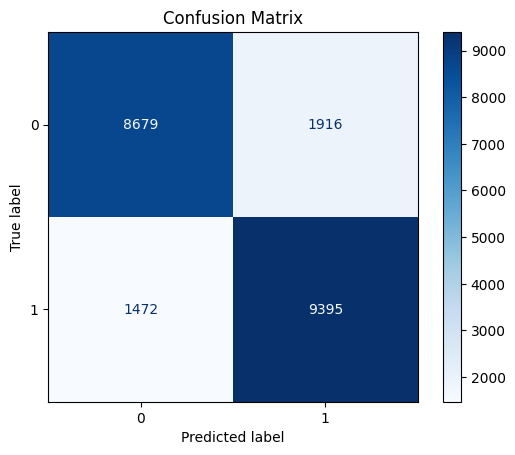

In [18]:
vectorizer = TfidfVectorizer(max_features=1000)
X_text_tfidf = vectorizer.fit_transform(X['combined_text'])
encoder = LabelEncoder()
X['sentiment_label_encoded'] = encoder.fit_transform(X['sentiment_label'])
X_non_text = X[['sentiment_label_encoded']].values
X_combined = hstack([X_text_tfidf, X_non_text])
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

model = MultinomialNB()
param_grid = {
    'alpha': np.logspace(-3, 1, 10),  
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(y_train.value_counts()) 
print(y_test.value_counts())   

In this model we included all of the changes as in the previous two models. We also added alpha and we set it to -3,1,10, which serves the purpose of smoothing the values, and possibly improivng the model.. The model accuracy droped from 85% to 84%, which is a minor change. We can see the minor changes in precission, recall,a nd f1-score, but overall it is still ballanced.

0 - Fake 1- Real

Overall this model correctly predicted 8679 fake news and 9396 real news, it also incorectly predicted 1916 fake news and 1471 real news.

# Conclusion

Model 2 demonstrated the best performance among all models evaluated. It achieved the highest accuracy score (0.861) and maintained a balanced performance across precision, recall, and F1-score for both classes. Additionally, it had the least number of incorrectly predicted values, making it the most reliable choice for this task based on these metrics.